In [1]:
# Created by: Chen Da
# Created on: 20191217

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random, warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import plotly as py
import plotly.graph_objs as go
import plotly.express as px

warnings.filterwarnings('ignore')

In [2]:
def final_model(df):
    predict_score = list()
    for info in range(df.shape[0]):
        new_data = df.iloc[info, :].values[1:-1]
        z = np.dot(new_data, coefs) + intercept
        y = 1 / (1 + np.exp(-z))
        predict_score.append(y)
    predict_df = pd.DataFrame(predict_score, columns=['pro'])
    df.index = [i for i in range(df.shape[0])]
    predict_df['id'] = df['id']
    predict_df['class'] = df['class']
    predict_df = predict_df.reindex(columns=['id', 'pro', 'class'])
    positive = predict_df[predict_df['class'] == 1]
    negtive = predict_df[predict_df['class'] == 0]
    plt.figure(figsize=(20, 12))
    plt.scatter(x=positive['id'], y=positive['pro'], color='red')
    plt.scatter(x=negtive['id'], y=negtive['pro'], color='blue')
    plt.axhline(y=0.5, color='grey', linestyle='--', alpha=0.6)
    plt.xticks(rotation=90)
    plt.grid()
    plt.show()
    predict_df['pre_label'] = predict_df['pro'].apply(lambda x: round(x))
    predict_df['class'] = predict_df['class'].apply(lambda x: int(x))
    pre_0_right = predict_df[np.logical_and(predict_df['class'] == 0, predict_df['pre_label'] == 0)].shape[0]
    pre_0_wrong = predict_df[np.logical_and(predict_df['class'] == 0, predict_df['pre_label'] == 1)].shape[0]
    pre_1_right = predict_df[np.logical_and(predict_df['class'] == 1, predict_df['pre_label'] == 1)].shape[0]
    pre_1_wrong = predict_df[np.logical_and(predict_df['class'] == 1, predict_df['pre_label'] == 0)].shape[0]
    print('总体准确率为%s' % ((pre_0_right + pre_1_right) / predict_df.shape[0]))
    return predict_df

In [3]:
def split_func(data_frame, size=0.8):
    """
    Split the data into two data set
    :param data_frame: the name of input data
    :param size : the size of train data
    :return: train_data, test_data
    """
    data_frame = pd.DataFrame(data_frame.values,
                              index=[i for i in range(data_frame.values.shape[0])],
                              columns=data_frame.columns)
    healthy_data = data_frame[data_frame["class"] == 0]
    unhealthy_data = data_frame[data_frame["class"] == 1]
    healthy_index = list(healthy_data.index)
    unhealthy_index = list(unhealthy_data.index)
    healthy_train_data_index = random.sample(healthy_index, int(size * len(healthy_index)))
    unhealthy_train_data_index = random.sample(unhealthy_index, int(size * len(unhealthy_index)))
    healthy_test_data_index = list(set(healthy_index).difference(set(healthy_train_data_index)))
    unhealthy_test_data_index = list(set(unhealthy_index).difference(set(unhealthy_train_data_index)))
    train_index = list(set(healthy_train_data_index).union(set(unhealthy_train_data_index)))
    test_index = list(set(healthy_test_data_index).union(set(unhealthy_test_data_index)))
    train = data_frame.iloc[train_index, :]
    test = data_frame.iloc[test_index, :]
    return train, test

In [4]:
path = 'C:/Users/pc/OneDrive/PLTTECH/Project/02_Disease_early_screening/lung_cancer/'
df_name = 'raw_data'
df = pd.read_excel(path + 'rawdata/' + df_name + '.xlsx')
df['id'] = df['id'].apply(lambda x:str(x))
pnasSubsetsIndex = [0,3,4,28,42,57,59,61,63,69,70,75,76,80,88,89,90,94,95,97,98,100,102]       
      
df = df.iloc[:, pnasSubsetsIndex]
# df.iloc[:, 1:-1] = df.iloc[:, 1:-1].multiply(100)
# stdsc = StandardScaler()
# df.iloc[:, 1:-1] = pd.DataFrame(stdsc.fit_transform(df.iloc[:, 1:-1].values), columns=df.columns[1:-1])
df.shape

(110, 23)

[0.001, 0.01, 0.1, 1.0, 10.0, 100.0]


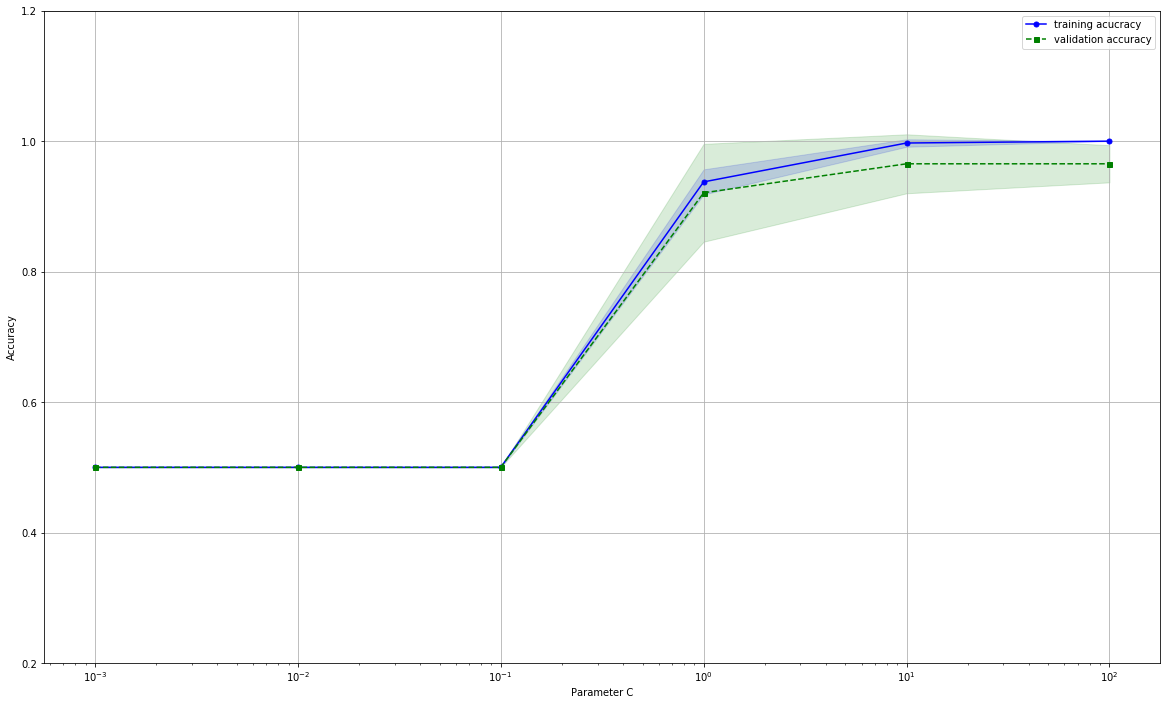

In [39]:
## 划分训练集和测试集
train_df, test_df = split_func(df)
X_train = train_df.iloc[:, 1:-1].values
y_train = train_df['class'].values.astype('int')
X_test = test_df.iloc[:, 1:-1].values
y_test = test_df['class'].values.astype('int')
# X_train = df.iloc[:, 1:-1].values
# y_train = df['class'].values.astype('int')

# 通过验证曲线来确定正则参数
# clf = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.9)
clf = LogisticRegression(penalty='l1')
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
# param_range = np.logspace(-6, 3, 20)
print(param_range)
train_scores, test_scores = validation_curve(estimator=clf, X=X_train, 
                                             y=y_train,
                                             param_name='C',
                                             param_range=param_range,
                                             cv=5)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(20,12))
plt.plot(param_range, train_mean, color='blue', marker='o',
         markersize=5, label='training acucracy')
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std,
                 alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--',
         marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='best')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1.2])
plt.show()                

In [40]:
lr = LogisticRegression(penalty='l1', C=10)
lr.fit(X_train, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [41]:
lr.score(X_train, y_train)

1.0

In [42]:
lr.score(X_test, y_test)

0.8636363636363636

In [43]:
coefs = list(lr.coef_[0])
intercept = lr.intercept_[0]
select_subsets_id = [list(lr.coef_[0]).index(i) for i in list(lr.coef_[0]) if i != 0]
select_subsets = [list(df.columns[1:-1])[i] for i in select_subsets_id]
print(len(select_subsets))
select_subsets.append('class')
select_subsets.insert(0, 'id')
print(select_subsets)
coefs = [i for i in coefs if i != 0]
print(coefs)
print(intercept)

11
['id', 'Lymphocytes/CD3+', 'Lymphocytes/CD3+/CD4+/Q2: 158Gd_CD197_CCR7+ , 155Gd_CD45RA+', 'Lymphocytes/CD3+/CD8+', 'Lymphocytes/CD3+/CD8+/PD1+', 'Lymphocytes/CD3+/CD8+/Q2: 158Gd_CD197_CCR7+ , 155Gd_CD45RA+', 'Lymphocytes/CD3-/B cells', 'Lymphocytes/CD3-/B cells/Q2: 145Nd_IgD+ , 153Eu_CD27+', 'Lymphocytes/CD3-/NK cells', 'Monocytes', 'Myeloid cells/CD56-CD14-/DC cells/mDC', 'Myeloid cells/HLA-DR-/MDSC', 'class']
[-9.712343104693268, -5.175384818383954, -8.424539855037779, 11.560320134694209, -7.58793856886243, 5.092406164620377, -0.6940297578640957, -7.205149919177772, 11.84668501014926, 11.474928669781105, 0.5118734349479953]
-1.3202925714388036


In [44]:
def predict_plot(df_name):
    data = pd.read_excel(path + 'rawdata/' + df_name + '.xlsx').iloc[:, pnasSubsetsIndex]
    score = lr.score(data.iloc[:, 1:-1].values, data['class'].values)
#     print('Predict Score is %s.' % score)
    probability = lr.predict_proba(data.iloc[:, 1:-1].values)[:, 1]
    pre_df = pd.DataFrame(probability, columns=['pro'])
    pre_df['class'] = data['class']
    pre_df['id'] = data['id']
    predict_df = pre_df.reindex(columns=['id', 'pro', 'class'])
    predict_df['class'] = predict_df['class'].apply(lambda x : str(x))
#     predict_df['id'] = predict_df['id'].apply(lambda x : str(x)+'_')
    predict_df = predict_df.sort_values(by='class')
    fig = px.scatter(predict_df, x='id', y='pro',
                     color='class', template='ggplot2', color_discrete_sequence=['green', '#EE0000'],
                     color_discrete_map={'0': 'green', '1': '#EE0000'})
    fig.add_trace(go.Scatter(x=[predict_df['id'].iloc[0, ], predict_df['id'].iloc[-1,]], y=[0.5, 0.5], 
                             mode='lines', 
                             line=dict(color='grey', dash='dash'),
                             showlegend=False))
    fig.update_layout(width=1200, height=800)
    fig.show()
    predict_df['pre_label'] = predict_df['pro'].apply(lambda x: round(x))
    predict_df['class'] = predict_df['class'].apply(lambda x: int(x))
    pre_0_right = predict_df[np.logical_and(predict_df['class'] == 0, predict_df['pre_label'] == 0)].shape[0]
    pre_0_wrong = predict_df[np.logical_and(predict_df['class'] == 0, predict_df['pre_label'] == 1)].shape[0]
    pre_1_right = predict_df[np.logical_and(predict_df['class'] == 1, predict_df['pre_label'] == 1)].shape[0]
    pre_1_wrong = predict_df[np.logical_and(predict_df['class'] == 1, predict_df['pre_label'] == 0)].shape[0]
    print('总体准确率为%s' % ((pre_0_right + pre_1_right) / predict_df.shape[0]))
    print('混淆矩阵为%s' % [pre_0_right, pre_0_wrong, pre_1_right, pre_1_wrong])
    return predict_df

In [45]:
# lung_cancer_new = pd.read_excel(path + 'rawdata/test_lung_cancer_new.xlsx').iloc[:, pnasSubsetsIndex]
pre_lung = predict_plot('test_lung')

总体准确率为0.6615384615384615
混淆矩阵为[0, 0, 43, 22]


In [76]:
healthy_new_pre = predict_plot('test_healthy')
# healthy_new_pre.to_excel('C:/Users/pc/Desktop/healthy_pre.xlsx')

总体准确率为0.7973856209150327
混淆矩阵为[122, 31, 0, 0]


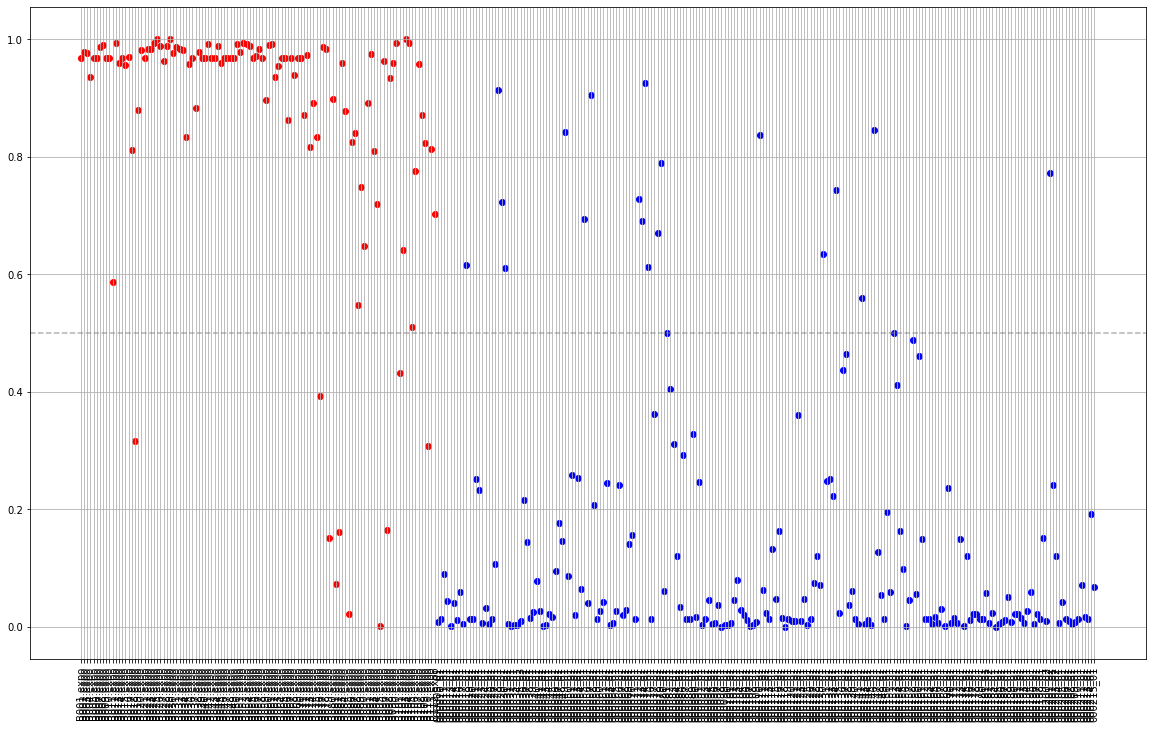

总体准确率为0.9090909090909091
混淆矩阵为[188, 19, 102, 10]


In [19]:
pre_all = predict_plot('all')

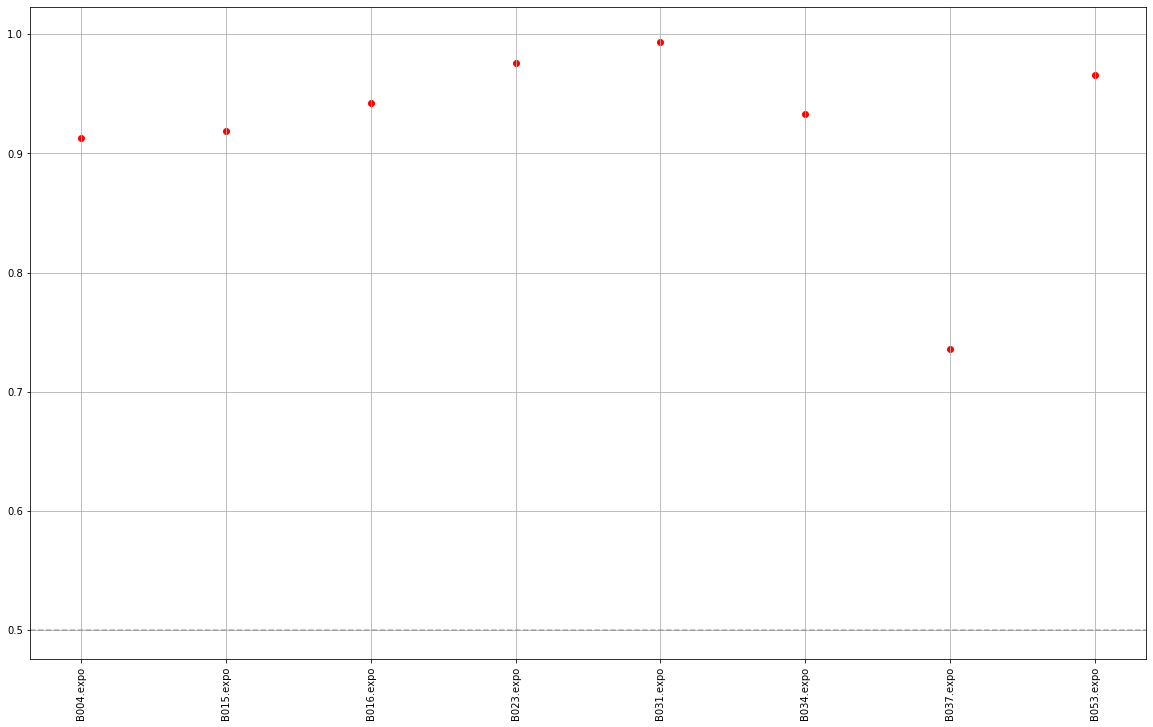

总体准确率为1.0
混淆矩阵为[0, 0, 8, 0]


In [142]:
benign_pre = predict_plot('test_benign')

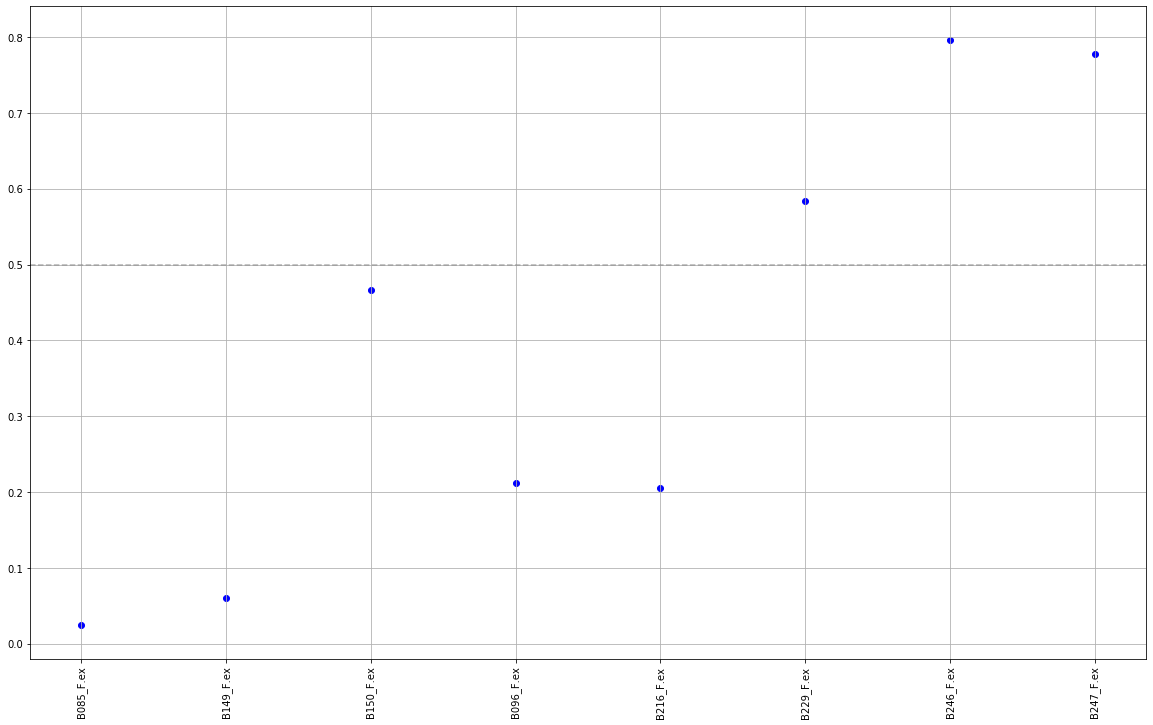

总体准确率为0.625
混淆矩阵为[5, 3, 0, 0]


In [143]:
PLT_healthy_pre = predict_plot('test_PLT_healthy')

In [87]:
# pulmonary_nodule = pd.read_excel(path + 'rawdata/test_pulmonary_nodule.xlsx').iloc[:, pnasSubsetsIndex]
# lr.score(pulmonary_nodule.iloc[:, 1:-1].values, pulmonary_nodule['class'].values)